In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import ttest_ind
import seaborn as sns
import re
import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model, neighbors
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Dataset

The dataset is downloaded from the Kaggle (https://www.kaggle.com/stefanoleone992/mutual-funds-and-etfs) that contains US ETF information, which is originally obtained from Yahoo Finance. The dataset is collected as of 2018/10, and the goal of the project is to find the best model to predict a fund's return.

In [2]:
etf_df = pd.read_csv('/Users/elizabeth/Desktop/Thinkful Data Science/Capstone_supervised learning/ETFs.csv')
pd.set_option('display.max_columns', None)

In [3]:
etf_df.head()

,fund_name,fund_extended_name,category,fund_family,net_assets,ytd_return,fund_yield,legal_type,investment,size,currency,net_annual_expense_ratio_fund,net_annual_expense_ratio_category,portfolio_stocks,portfolio_bonds,price_earnings,price_book,price_sales,price_cashflow,basic_materials,consumer_cyclical,financial_services,real_estate,consumer_defensive,healthcare,utilities,communication_services,energy,industrials,technology,rating_us_government,rating_aaa,rating_aa,rating_a,rating_bbb,rating_bb,rating_b,rating_below_b,rating_others,fund_return_ytd,category_return_ytd,fund_return_1month,category_return_1month,fund_return_3months,category_return_3months,fund_return_1year,category_return_1year,fund_return_3years,category_return_3years,fund_return_5years,category_return_5years,fund_return_10years,category_return_10years,fund_return_2018,fund_return_2017,fund_return_2016,fund_return_2015,fund_return_2014,fund_return_2013,fund_return_2012,fund_return_2011,fund_return_2010,fund_alpha_3years,category_alpha_3years,fund_alpha_5years,category_alpha_5years,fund_alpha_10years,category_alpha_10years,fund_beta_3years,category_beta_3years,fund_beta_5years,category_beta_5years,fund_beta_10years,category_beta_10years,fund_mean_annual_return_3years,category_mean_annual_return_3years,fund_mean_annual_return_5years,category_mean_annual_return_5years,fund_mean_annual_return_10years,category_mean_annual_return_10years,fund_r_squared_3years,category_r_squared_3years,fund_r_squared_5years,category_r_squared_5years,fund_r_squared_10years,category_r_squared_10years,fund_standard_deviation_3years,category_standard_deviation_3years,fund_standard_deviation_5years,category_standard_deviation_5years,fund_standard_deviation_10years,category_standard_deviation_10years,fund_sharpe_ratio_3years,category_sharpe_ratio_3years,fund_sharpe_ratio_5years,category_sharpe_ratio_5years,fund_sharpe_ratio_10years,category_sharpe_ratio_10years,fund_treynor_ratio_3years,category_treynor_ratio_3years,fund_treynor_ratio_5years,category_treynor_ratio_5years,fund_treynor_ratio_10years,category_treynor_ratio_10years
0,1305,Daiwa ETF TOPIX,NaN,Daiwa Asset Management Co Ltd,4.010000e+12,NaN,1.84,Exchange Traded Fund,Blend,Large,USD,0.00,NaN,100.00,0.0,12.92,1.18,0.81,5.41,7.81,17.26,11.73,3.19,9.44,7.05,1.96,4.95,1.70,20.29,14.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.62,0.0,1.22,0.0,-3.11,0.0,-5.17,0.0,3.83,0.0,7.86,0.0,9.25,0.0,NaN,22.06,0.17,11.90,10.12,54.10,20.69,-17.07,0.84,0.29,NaN,0.39,NaN,0.35,NaN,1.00,NaN,0.98,NaN,0.99,NaN,0.40,NaN,0.72,NaN,0.86,NaN,99.72,NaN,99.70,NaN,99.68,NaN,14.38,NaN,14.75,NaN,16.89,NaN,0.34,NaN,0.59,NaN,0.60,NaN,3.92,NaN,8.01,NaN,9.29,NaN
1,1306,Nomura TOPIX ETF,NaN,Nomura Asset Management Co Ltd,8.430000e+12,NaN,1.77,Exchange Traded Fund,Blend,Large,USD,0.05,NaN,99.99,0.0,12.92,1.18,0.81,5.41,7.81,17.26,11.73,3.19,9.43,7.06,1.96,4.95,1.70,20.29,14.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.43,0.0,1.30,0.0,-3.10,0.0,-5.21,0.0,3.88,0.0,7.87,0.0,9.27,0.0,NaN,22.06,0.21,11.91,10.13,54.12,20.64,-17.04,0.93,0.31,NaN,0.40,NaN,0.38,NaN,1.00,NaN,0.98,NaN,0.98,NaN,0.41,NaN,0.72,NaN,0.86,NaN,99.72,NaN,99.69,NaN,99.68,NaN,14.38,NaN,14.75,NaN,16.83,NaN,0.34,NaN,0.59,NaN,0.61,NaN,3.94,NaN,8.03,NaN,9.33,NaN
2,1308,Nikko Exchange Traded Index TOPIX,NaN,Nikko Asset Management Co Ltd,3.730000e+12,NaN,1.84,Exchange Traded Fund,Blend,Large,USD,0.00,NaN,99.08,0.0,12.92,1.18,0.81,5.44,7.74,17.33,11.57,3.22,9.53,7.07,1.99,4.98,1.70,20.23,14.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.47,0.0,1.31,0.0,-3.08,0.0,-5.09,0.0,3.85,0.0,7.87,0.0,9.22,0.0,NaN,22.09,0.18,11.92,10.13,54.19,20.70,-17.06,0.87,0.30,NaN,0.41,NaN,0.36,NaN,1.00,NaN,0.98,NaN,0.99,NaN,0.40,NaN,0.72,NaN,0.86,NaN,99.72,NaN,99.69,NaN,99.68,NaN,14.38,NaN,14.75,NaN,16.90,NaN,0.34,NaN,0.59,NaN,0.60,NaN,3.93,NaN,8.03,NaN,9.31,NaN
3,1309,Nomura SSE50 Index Link ETF,NaN,Nomura Asset Management Co Ltd,4.450000e+09,NaN,0.00,Exchange Traded Fund,Value,Large,USD,0.00,NaN,18.57,0.0,12.09,1.01,0.56,3.86,6.38,13.36,14.15,0.00,

In [4]:
etf_df.shape

(2352, 104)

In [5]:
etf_df.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

In [6]:
etf_df_obj = etf_df.select_dtypes(include=['object'])

In [7]:
etf_df_obj.nunique()

fund_name                        2352
fund_extended_name               2340
category                           95
fund_family                       174
legal_type                          1
investment                          3
size                                3
currency                            3
fund_treynor_ratio_3years        1248
category_treynor_ratio_5years      78
dtype: int64

In [8]:
# convert "fund_treynor_ratio_3years" and "category_treynor_ratio_5years" to floating data type
etf_df['fund_treynor_ratio_3years'] = etf_df['fund_treynor_ratio_3years'].str.replace(',', '').astype('float')
etf_df['category_treynor_ratio_5years'] = etf_df['category_treynor_ratio_5years'].str.replace(',', '').astype('float')

In [9]:
etf_df_obj = etf_df.select_dtypes(include=['object'])

In [10]:
etf_df_obj.nunique()

fund_name             2352
fund_extended_name    2340
category                95
fund_family            174
legal_type               1
investment               3
size                     3
currency                 3
dtype: int64

In [11]:
etf_df_num = etf_df.select_dtypes(include=['float64'])

In [12]:
print('Number of categorical features is {}'.format(etf_df_obj.shape[1]))
print('Number of categorical features is {}'.format(etf_df_num.shape[1]))

Number of categorical features is 8
Number of categorical features is 96


The dataset contains 2,352 ETFs with general aspects (such as total net assets, management company and size), portfolio indicators (such as cash, stocks, bonds, and sectors), returns (as year_to_date, 2018-10) and financial ratios (such as price/earning, alpha, beta, Treynor and Sharpe ratios). It also contains performance of different sector. There are 104 features in total. After correcting the data type of 2 features, there are 8 categorical features and 96 numercial features.

## Data Exploration

Taking a look at all the features available, R-squared doesn't make too much sense when looking at an ETF data. We'll drop all the columns that contain r_squared. There are a few columns contain ytd return. It's unclear the difference between ytd and the return of 2018, and is very like that its bad and duplicated data with 2018 return. We should drop them. Clearly fund's name or family should be related to a fund's return. Drop columns fund_name, fund_extended_name and fund_family.

In [13]:
drop_list_1 = []
for i in etf_df.columns.tolist():
    if re.search(r'r_squared', i) or re.search(r'ytd', i):
        drop_list_1.append(i)

drop_list_2 = ['fund_name', 'fund_extended_name', 'fund_family']
etf_df = etf_df.drop(columns=drop_list_1)
etf_df = etf_df.drop(columns=drop_list_2)
print('Number of columns is now {}'.format(etf_df.shape[1]))

Number of columns is now 92


### Missing values

In [14]:
etf_missing = etf_df.isnull().sum()*100/etf_df.isnull().count()
etf_missing.sort_values(ascending=False).head(50)

fund_return_2010                       63.775510
fund_return_2011                       57.057823
category_treynor_ratio_10years         51.913265
category_standard_deviation_10years    51.913265
category_beta_10years                  51.913265
category_mean_annual_return_10years    51.913265
category_alpha_10years                 51.913265
category_sharpe_ratio_10years          51.913265
fund_return_2012                       50.935374
fund_return_2013                       45.620748
fund_return_2014                       39.795918
category_sharpe_ratio_5years           38.818027
category_beta_5years                   38.818027
category_alpha_5years                  38.818027
category_treynor_ratio_5years          38.818027
category_mean_annual_return_5years     38.818027
category_standard_deviation_5years     38.818027
category_standard_deviation_3years     38.307823
category_treynor_ratio_3years          38.307823
category_beta_3years                   38.307823
category_mean_annual

In [15]:
etf_df_obj_missing = etf_df_obj.isnull().sum()*100/etf_df_obj.isnull().count()
etf_df_obj_missing
# etf_df_obj_missing_df = pd.DataFrame(etf_df_obj_missing, columns=['Missing Perc'])
# etf_df_obj_missing_df

fund_name              0.000000
fund_extended_name     0.000000
category              22.108844
fund_family            0.000000
legal_type             0.000000
investment            29.336735
size                  29.336735
currency               0.000000
dtype: float64

In [16]:
etf_df['category'].nunique()

95

Investment and size are missing at the same time. We can drop column size, as size is determined by net_assets, which contains less missing value. Fill missing net_assets by the average of its size group, and then drop size column. Drop category column as it's a combination of many other features, and difficult to fill in the missing values with the limited information.

In [17]:
etf_df["net_assets"].isnull().sum()*100/etf_df["net_assets"].isnull().count()

0.8503401360544217

In [18]:
etf_df["net_assets"] = etf_df["net_assets"].fillna(etf_df.groupby('size')['net_assets'].transform('mean'))
etf_df["net_assets"] = etf_df["net_assets"].fillna(etf_df['net_assets'].mean())
etf_df = etf_df.drop(columns=['size', 'category'])

Drop records missing investment type (Tried to fill in the investment type by the most frequent one, but gave worse result)

In [19]:
etf_df = etf_df.dropna(subset=["investment"]).reset_index()
print('Number of records is now {}'.format(etf_df.shape[0]))
print('Number of columns is now {}'.format(etf_df.shape[1]))

Number of records is now 1662
Number of columns is now 91


Looking at the features with a lot of missing values. There are mostly features that require longer period of time, and features of the fund's category. A large number of funds don't exist for more than 3 years, so drop all the features that represents more than 5 years of performance.

In [20]:
drop_list_3 = []
for i in etf_df.columns.tolist():
    if re.search(r'2010', i) or re.search(r'2011', i) or re.search(r'2012', i) or re.search(r'2013', i) or re.search(r'2014', i):
        drop_list_3.append(i)

print('Number of columns to drop is {}'.format(len(drop_list_3)))
etf_df = etf_df.drop(columns=drop_list_3)
print('Number of records is now {}'.format(etf_df.shape[0]))
print('Number of columns is now {}'.format(etf_df.shape[1]))

Number of columns to drop is 5
Number of records is now 1662
Number of columns is now 86


In [21]:
drop_list_4 = []
for i in etf_df.columns.tolist():
    if re.search(r'5years$', i) or re.search(r'10years$', i):
        drop_list_4.append(i)

print('Number of columns to drop is {}'.format(len(drop_list_4)))
etf_df = etf_df.drop(columns=drop_list_4)
print('Number of records is now {}'.format(etf_df.shape[0]))
print('Number of columns is now {}'.format(etf_df.shape[1]))

Number of columns to drop is 28
Number of records is now 1662
Number of columns is now 58


Noticing there are a lot of records are 0. Take a look at if they make sense.

In [22]:
etf_zeros = (etf_df.isin([0]).sum()*100/etf_df.isin([0]).count()).sort_values(ascending = False).head(50)
etf_zeros

rating_us_government                 99.819495
rating_below_b                       96.750903
rating_b                             96.269555
rating_bb                            96.149218
rating_others                        96.028881
rating_aa                            95.066185
rating_a                             94.945848
rating_bbb                           94.464501
rating_aaa                           93.622142
portfolio_bonds                      89.410349
utilities                            35.619735
real_estate                          34.175692
category_return_3years               33.694344
category_return_3months              33.453670
category_return_1year                33.453670
category_return_1month               33.453670
communication_services               32.490975
energy                               30.926594
healthcare                           30.264741
consumer_defensive                   29.542720
financial_services                   25.992780
basic_materia

In [23]:
etf_df['rating_us_government'].describe()

count    1659.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: rating_us_government, dtype: float64

Drop all columns with rating because most of the ratings data are missing.

In [24]:
drop_list_5 = []
for i in etf_df.columns.tolist():
    if re.search(r'^rating', i):
        drop_list_5.append(i)

print('Number of columns to drop is {}'.format(len(drop_list_5)))
etf_df = etf_df.drop(columns=drop_list_5)
print('Number of records is now {}'.format(etf_df.shape[0]))
print('Number of columns is now {}'.format(etf_df.shape[1]))

Number of columns to drop is 9
Number of records is now 1662
Number of columns is now 49


In [67]:
etf_df.columns.tolist()

['fund_yield',
 'portfolio_bonds',
 'price_earnings',
 'price_book',
 'price_sales',
 'price_cashflow',
 'consumer_cyclical',
 'financial_services',
 'real_estate',
 'healthcare',
 'utilities',
 'energy',
 'technology',
 'fund_return_1month',
 'fund_return_3months',
 'category_return_3months',
 'fund_return_1year',
 'category_return_1year',
 'fund_return_3years',
 'category_return_3years',
 'fund_return_2018',
 'fund_return_2017',
 'fund_return_2016',
 'fund_return_2015',
 'fund_alpha_3years',
 'category_alpha_3years',
 'category_mean_annual_return_3years',
 'fund_standard_deviation_3years',
 'fund_treynor_ratio_3years',
 'category_treynor_ratio_3years']

Now take a look at missing value and 0 value at the same time:

In [26]:
etf_missing = pd.DataFrame(etf_df.isnull().sum()*100/etf_df.isnull().count(), columns=['missing perc'])
etf_zeros = pd.DataFrame(etf_df.isin([0]).sum()*100/etf_df.isin([0]).count(), columns=['zero perc'])
etf_temp = pd.concat([etf_missing,etf_zeros], axis=1)
etf_temp

,missing perc,zero perc
index,0.000000,0.060168
net_assets,0.000000,0.000000
fund_yield,0.661853,6.257521
legal_type,0.000000,0.000000
investment,0.000000,0.000000
currency,0.000000,0.000000
net_annual_expense_ratio_fund,0.000000,6.016847
net_annual_expense_ratio_category,23.225030,0.060168
portfolio_stocks,0.180505,4.091456
portfolio_bonds,0.180505,89.410349


For the rest of the data, fill missing value using mean

In [27]:
etf_df.isnull().sum()*100/etf_df.isnull().count() 

index                                  0.000000
net_assets                             0.000000
fund_yield                             0.661853
legal_type                             0.000000
investment                             0.000000
currency                               0.000000
net_annual_expense_ratio_fund          0.000000
net_annual_expense_ratio_category     23.225030
portfolio_stocks                       0.180505
portfolio_bonds                        0.180505
price_earnings                         0.180505
price_book                             0.180505
price_sales                            0.180505
price_cashflow                         0.180505
basic_materials                        0.180505
consumer_cyclical                      0.180505
financial_services                     0.180505
real_estate                            0.180505
consumer_defensive                     0.180505
healthcare                             0.180505
utilities                              0

In [28]:
etf_df.fillna(etf_df.mean(), inplace=True)

In [29]:
etf_df_num = etf_df.select_dtypes(include=['float64'])
etf_df_obj = etf_df.select_dtypes(include=['object'])

In [30]:
etf_df_num.describe()

,net_assets,fund_yield,net_annual_expense_ratio_fund,net_annual_expense_ratio_category,portfolio_stocks,portfolio_bonds,price_earnings,price_book,price_sales,price_cashflow,basic_materials,consumer_cyclical,financial_services,real_estate,consumer_defensive,healthcare,utilities,communication_services,energy,industrials,technology,fund_return_1month,category_return_1month,fund_return_3months,category_return_3months,fund_return_1year,category_return_1year,fund_return_3years,category_return_3years,fund_return_2018,fund_return_2017,fund_return_2016,fund_return_2015,fund_alpha_3years,category_alpha_3years,fund_beta_3years,category_beta_3years,fund_mean_annual_return_3years,category_mean_annual_return_3years,fund_standard_deviation_3years,category_standard_deviation_3years,fund_sharpe_ratio_3years,category_sharpe_ratio_3years,fund_treynor_ratio_3years,category_treynor_ratio_3years
count,1.662000e+03,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000
mean,2.834994e+10,2.162096,0.471751,0.499600,89.423189,4.978113,14.862357,2.030946,1.574539,7.488758,7.484057,10.913237,15.159542,6.998764,7.183659,9.127914,4.680024,3.144822,6.919126,11.029735,13.260265,0.714207,-0.290916,10.306130,2.001971,0.208620,6.949831,7.002923,3.414690,-11.136613,21.459401,11.565197,-4.125817,-0.336048,0.490673,0.865712,0.980645,0.685548,0.496755,12.329867,14.094564,0.509107,0.503445,6.654858,6.972782
std,3.452971e+11,1.651520,0.405512,0.143296,26.034081,19.685970,5.738260,1.138768,1.195857,3.878050,14.723939,12.583290,18.586421,17.703273,11.165546,16.523444,11.224867,4.879056,15.738910,13.620768,16.964784,3.023582,1.695163,9.487292,3.329309,10.352348,8.834272,7.202235,5.359344,8.923714,16.241038,15.142247,11.209570,5.143900,4.106652,0.612886,0.166794,0.595200,0.366947,10.132379,4.163342,0.421667,0.336513,8.396262,7.259641
min,6.937500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-26.630000,-6.170000,-19.640000,-14.960000,-55.010000,-4.150000,-33.070000,-15.940000,-79.740000,-42.830000,-63.610000,-97.090000,-57.860000,-16.860000,-1.770000,0.140000,-0.960000,-1.340000,0.000000,2.430000,-3.980000,-0.980000,-23.970000,-18.010000
25%,3.101000e+07,1.122500,0.250000,0.400000,98.465000,0.000000,12.072500,1.360000,0.910000,5.140000,0.092500,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.870000,0.480000,-0.517500,-0.250000,6.367500,0.000000,-5.870000,0.000000,0.000000,0.000000,-13.825000,14.342500,4.620000,-4.387500,-1.620000,-0.650000,0.680000,0.980000,0.222500,0.400000,9.240000,12.420000,0.190000,0.335000,1.090000,3.620000
50%,1.780500e+08,1.900000,0.430000,0.499600,99.600000,0.000000,14.400000,1.760000,1.240000,6.990000,4.130000,10.635000,13.255000,2.280000,5.690000,5.720000,2.230000,2.040000,3.130000,9.685000,9.435000,0.780000,0.000000,11.195000,2.001971,0.375000,5.295000,6.975000,0.780000,-11.136613,21.459401,11.565197,-4.125817,0.000000,0.490673,0.950000,0.980645,0.685548,0.496755,12.180000,14.094564,0.530000,0.503445,6.654858,6.972782
75%,9.752500e+08,2.850000,0.627500,0.530000,99.860000,0.000000,17.020000,2.440000,1.910000,9.080000,8.190000,14.427500,19.565000,5.930000,9.557500,11.720000,4.587500,4.367500,6.622500,14.302500,17.577500,1.950000,0.310000,14.387500,4.740000,6.250000,12.420000,11.177500,8.340000,-6.340000,25.090000,14.045000,0.350000,0.740000,0.520000,1.090000,1.030000,0.980000,0.730000,14.897500,14.310000,0.780000,0.71000

### Data Visualization

Draw box plots and histograms to take a look at the range and distribution of numerical features

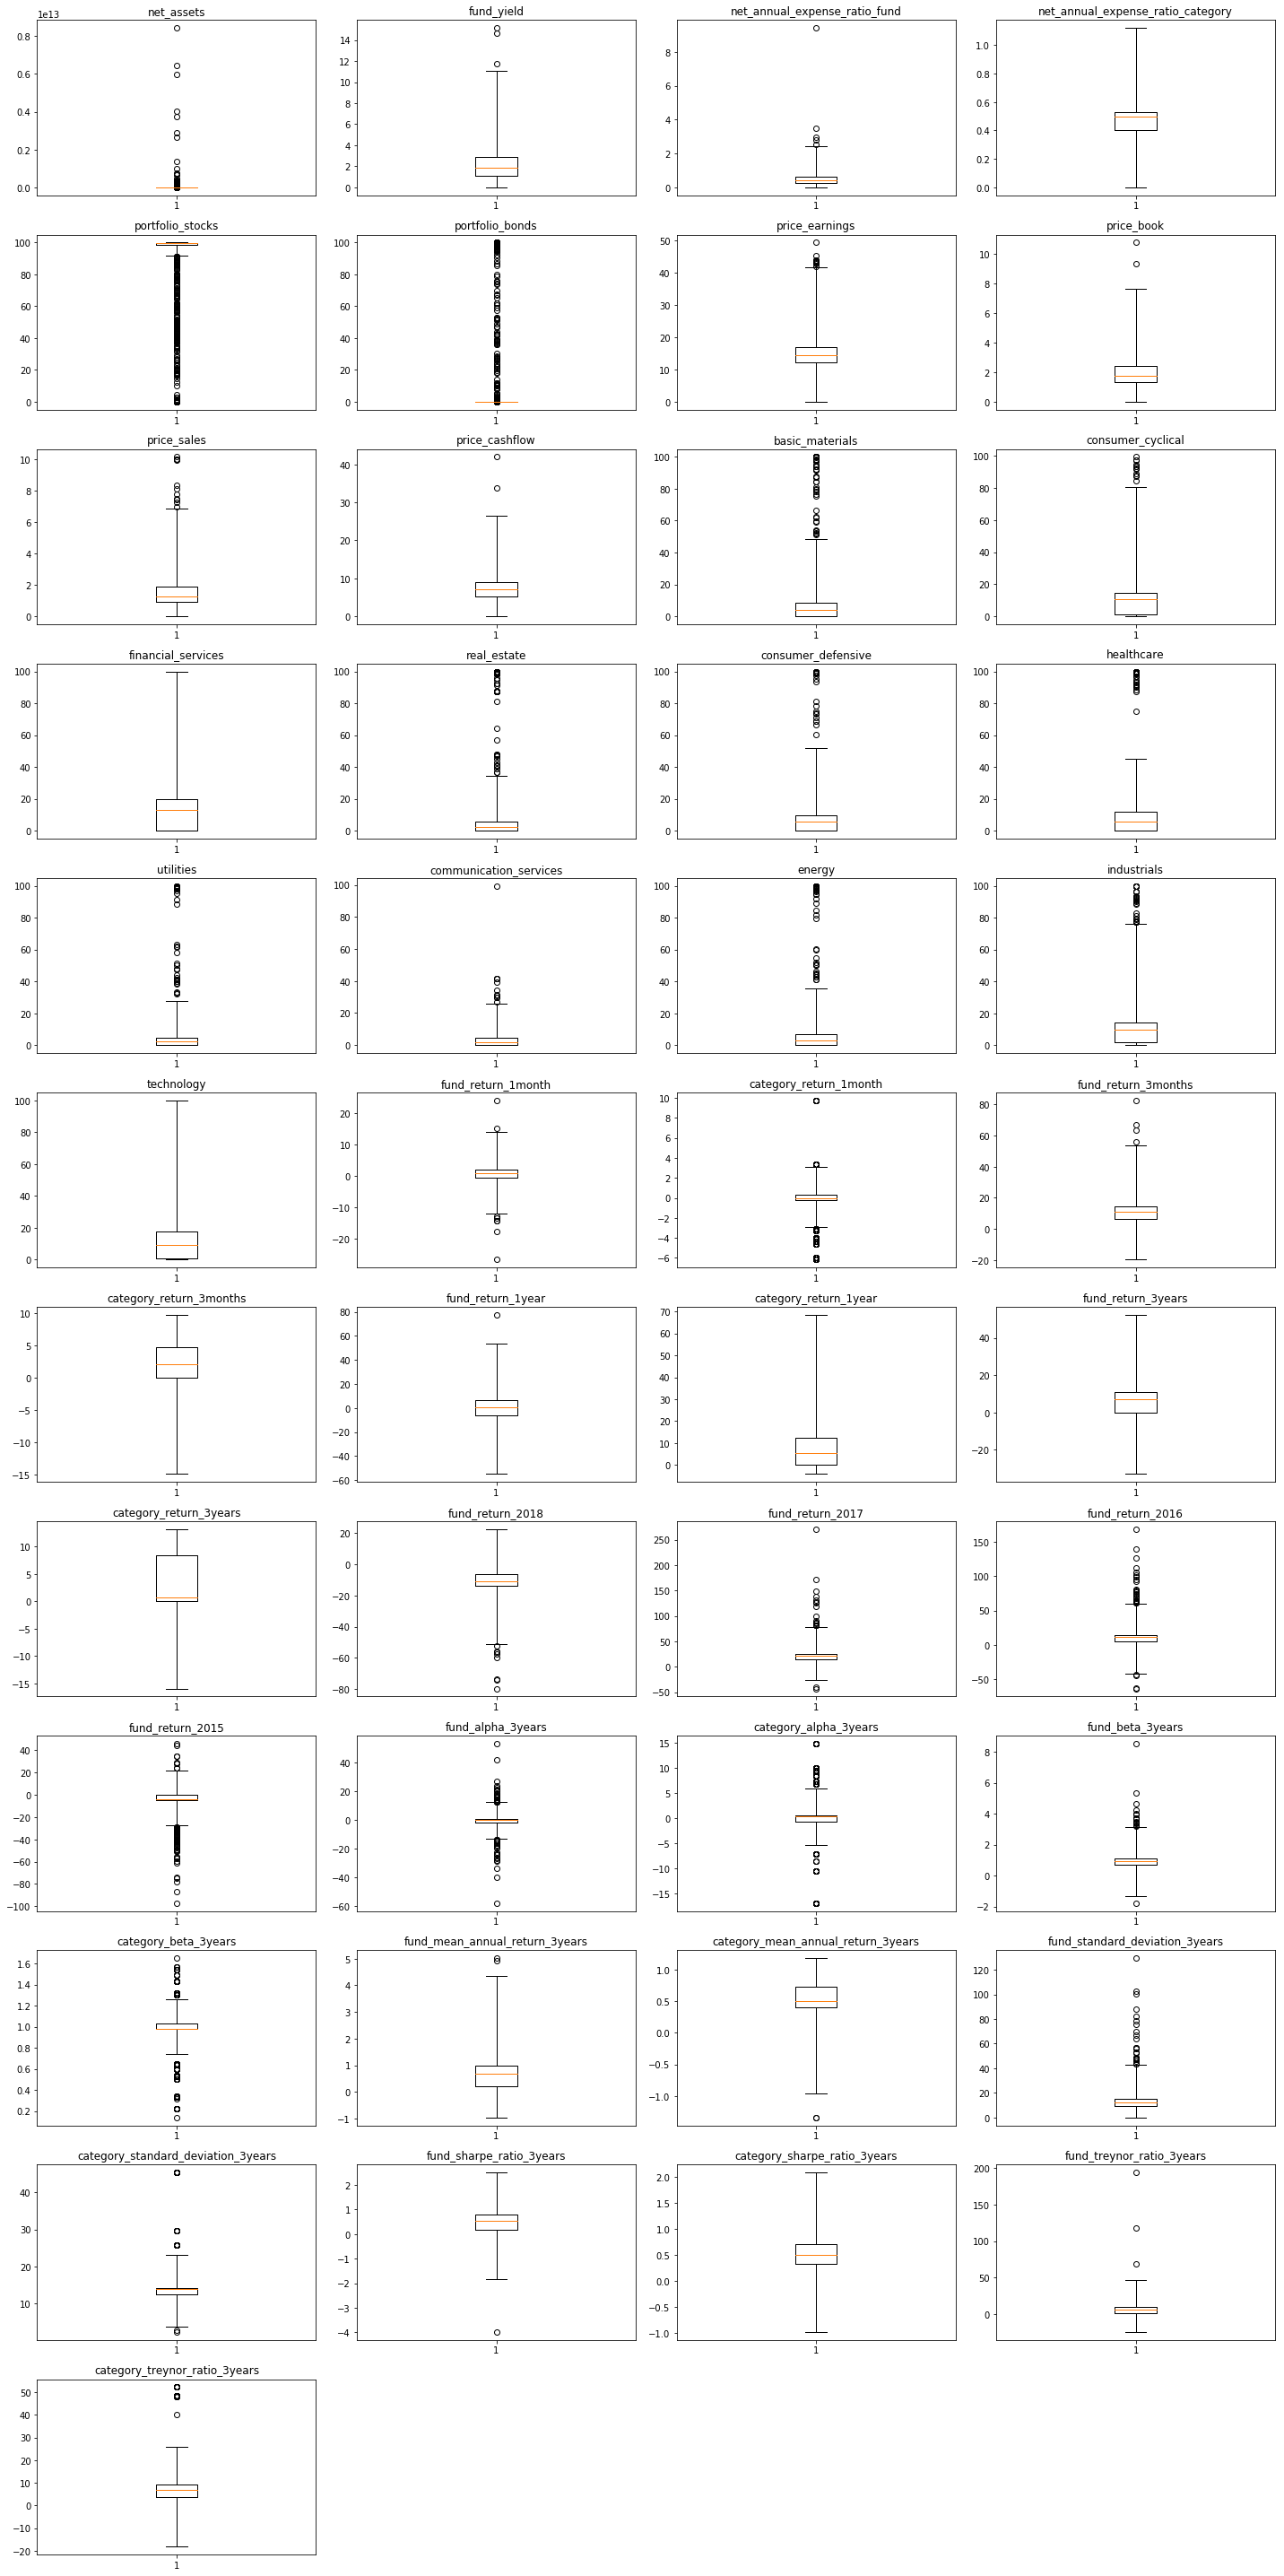

In [31]:
full_list = etf_df_num.columns.tolist()


fig = plt.figure(figsize=(20,40))

for i, col in enumerate (full_list):
        plt.subplot(12, 4, i+1)
        plt.boxplot(etf_df_num[col], whis=5)
        plt.title(col)
    
plt.tight_layout()
plt.show()

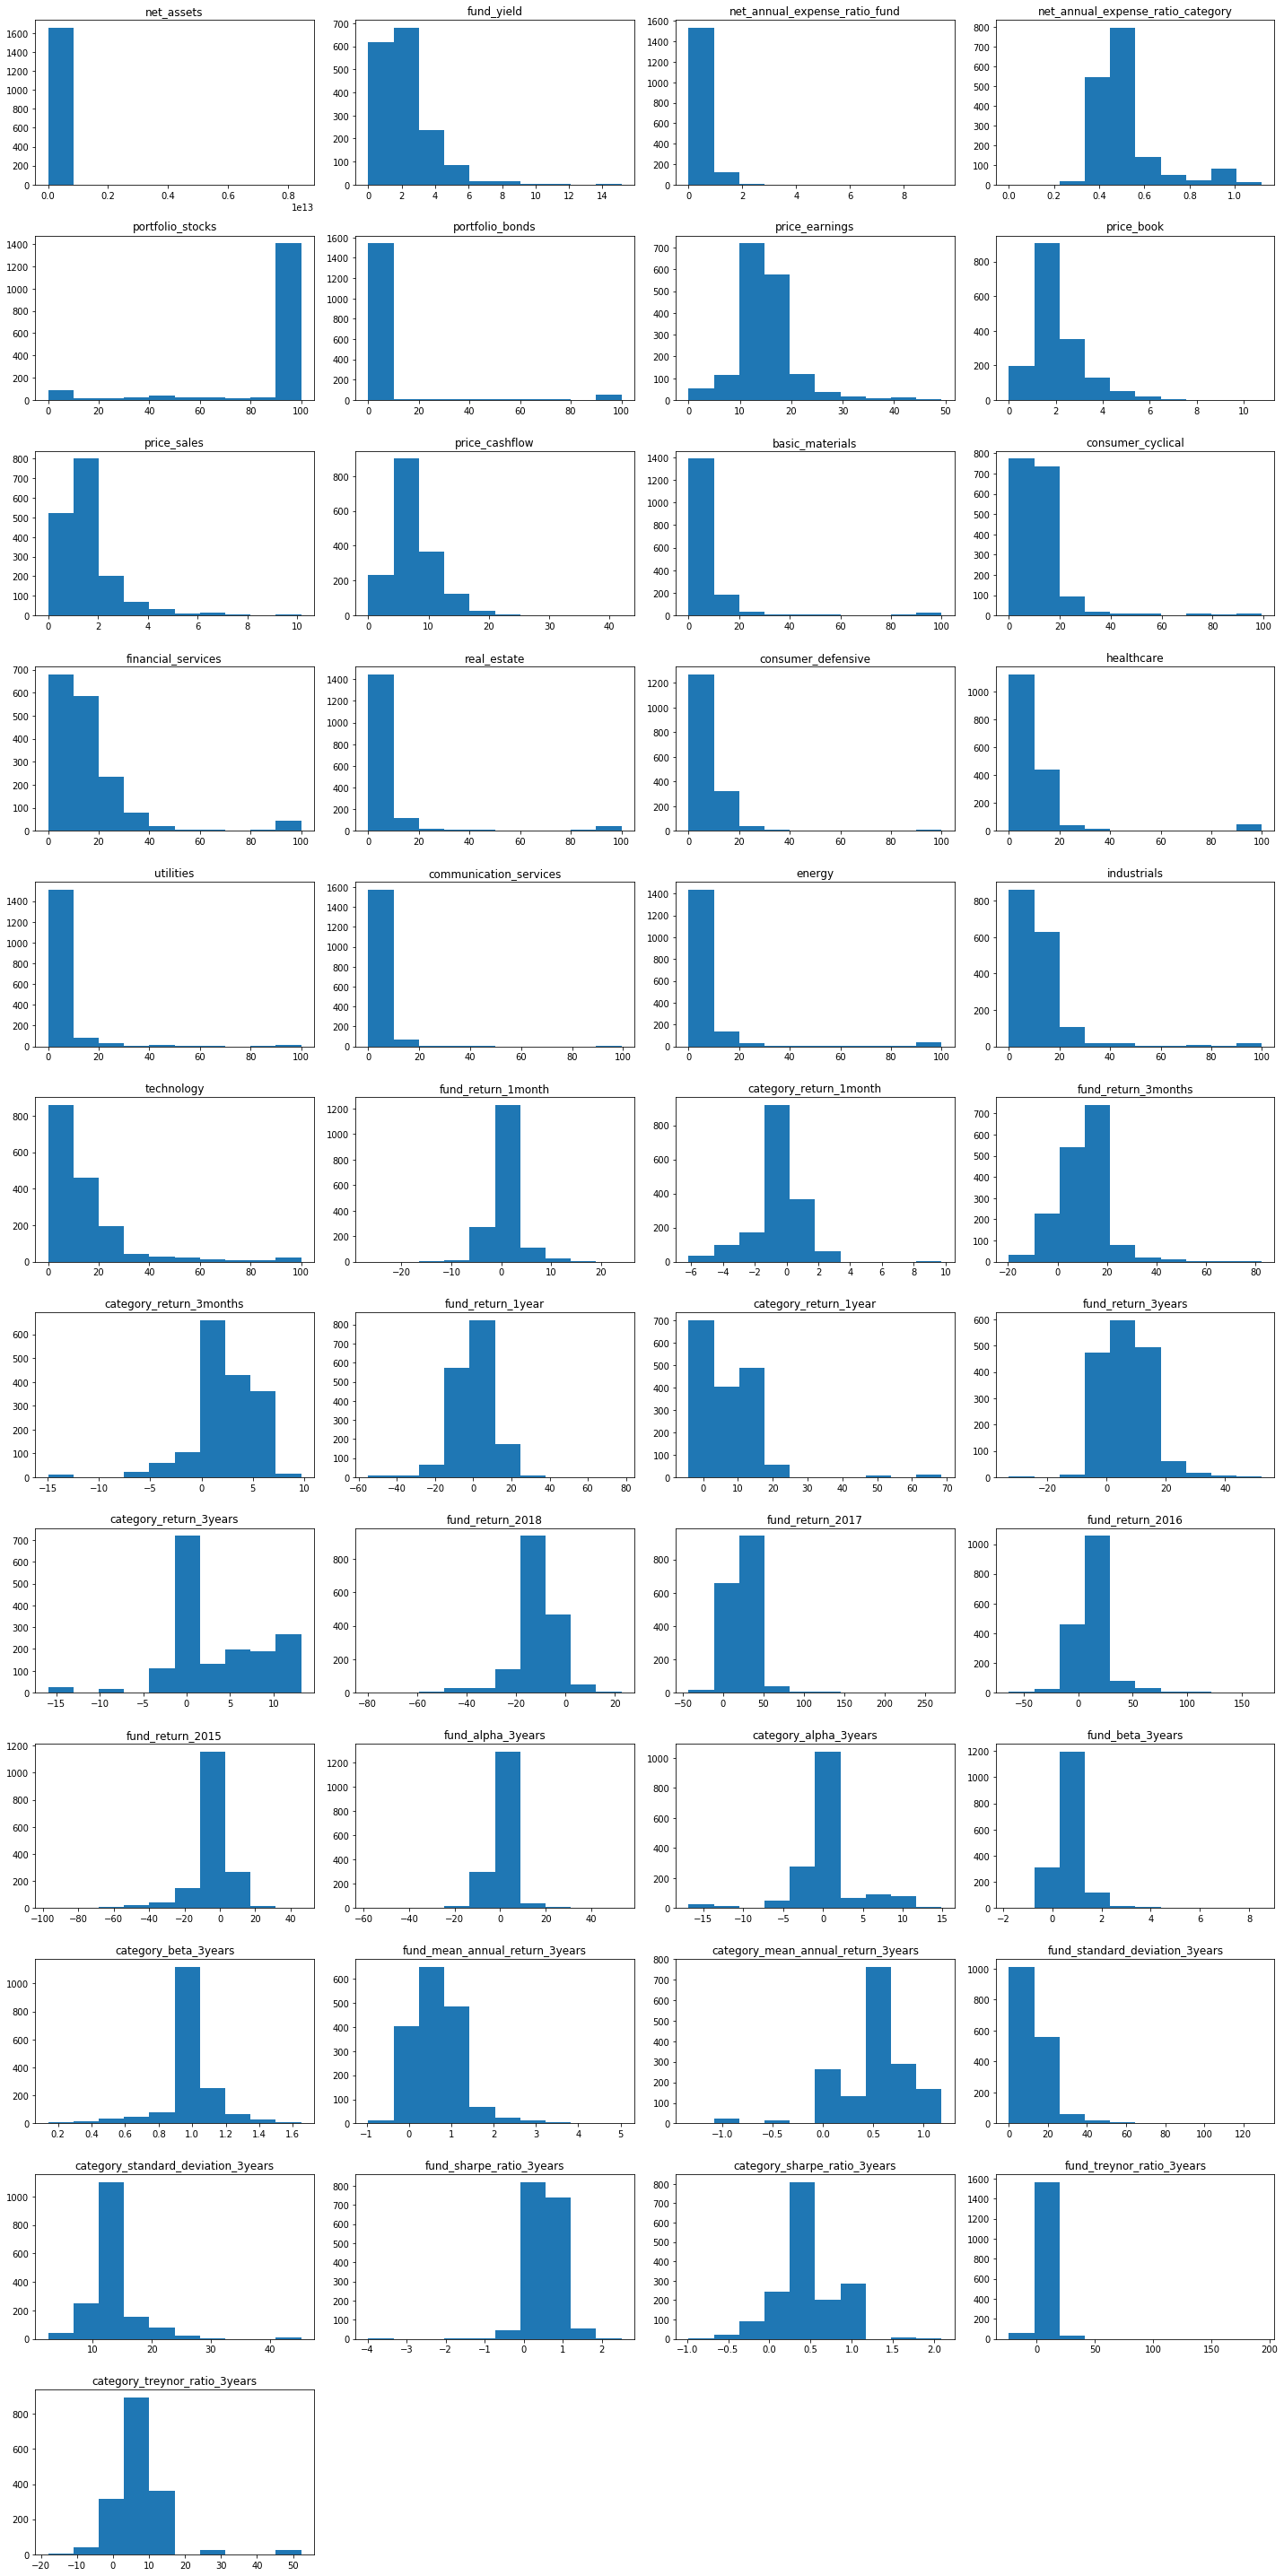

In [32]:
full_list = etf_df_num.columns.tolist()


fig = plt.figure(figsize=(20,40))

for i, col in enumerate (full_list):
        plt.subplot(12, 4, i+1)
        plt.hist(etf_df_num[col])
        plt.title(col)
    
plt.tight_layout()
plt.show()

Although the data is not normally distributed, but there are not out of the reasonable range, and they could all be representative. So there is no need to apply scalar or winsorize the data.

In [33]:
# Tried using standard scaler but gave very similar result. 
# scaler = StandardScaler()
# etf_df_num_scaled = pd.DataFrame(scaler.fit_transform(etf_df_num), columns=etf_df_num.columns)

In [34]:
etf_df_obj.describe()

,legal_type,investment,currency
count,1662,1662,1662
unique,1,3,3
top,Exchange Traded Fund,Blend,USD
freq,1662,759,1655


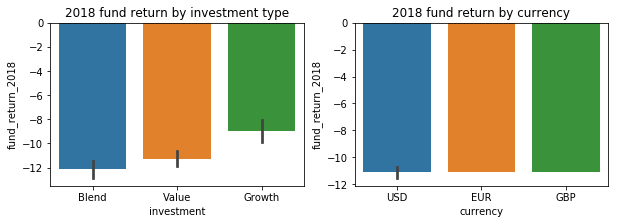

In [35]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
sns.barplot(etf_df["investment"], etf_df["fund_return_2018"])
plt.title("2018 fund return by investment type")


plt.subplot(1,2,2)
sns.barplot(etf_df["currency"], etf_df["fund_return_2018"])
plt.title("2018 fund return by currency")

plt.show()

In [36]:
etf_df["currency"].describe()

count     1662
unique       3
top        USD
freq      1655
Name: currency, dtype: object

Currency doesn't make too much difference in fund return in 2018. There is only one fund in EUR and GBP each. We'll only create dummy vairables for investment type.

In [37]:
etf_df_dummy = pd.get_dummies(etf_df[['investment']])
etf_df = pd.concat([etf_df_num, etf_df_dummy], ignore_index=False, axis=1, sort=False)

### Feature Selection

Run regression for fund_return_2018 against other features

In [38]:
Y = etf_df['fund_return_2018']
X = etf_df.loc[:,etf_df.columns!='fund_return_2018']

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       fund_return_2018   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     162.8
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        00:26:37   Log-Likelihood:                -4558.1
No. Observations:                1662   AIC:                             9210.
Df Residuals:                    1615   BIC:                             9465.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

Check correlation among all features

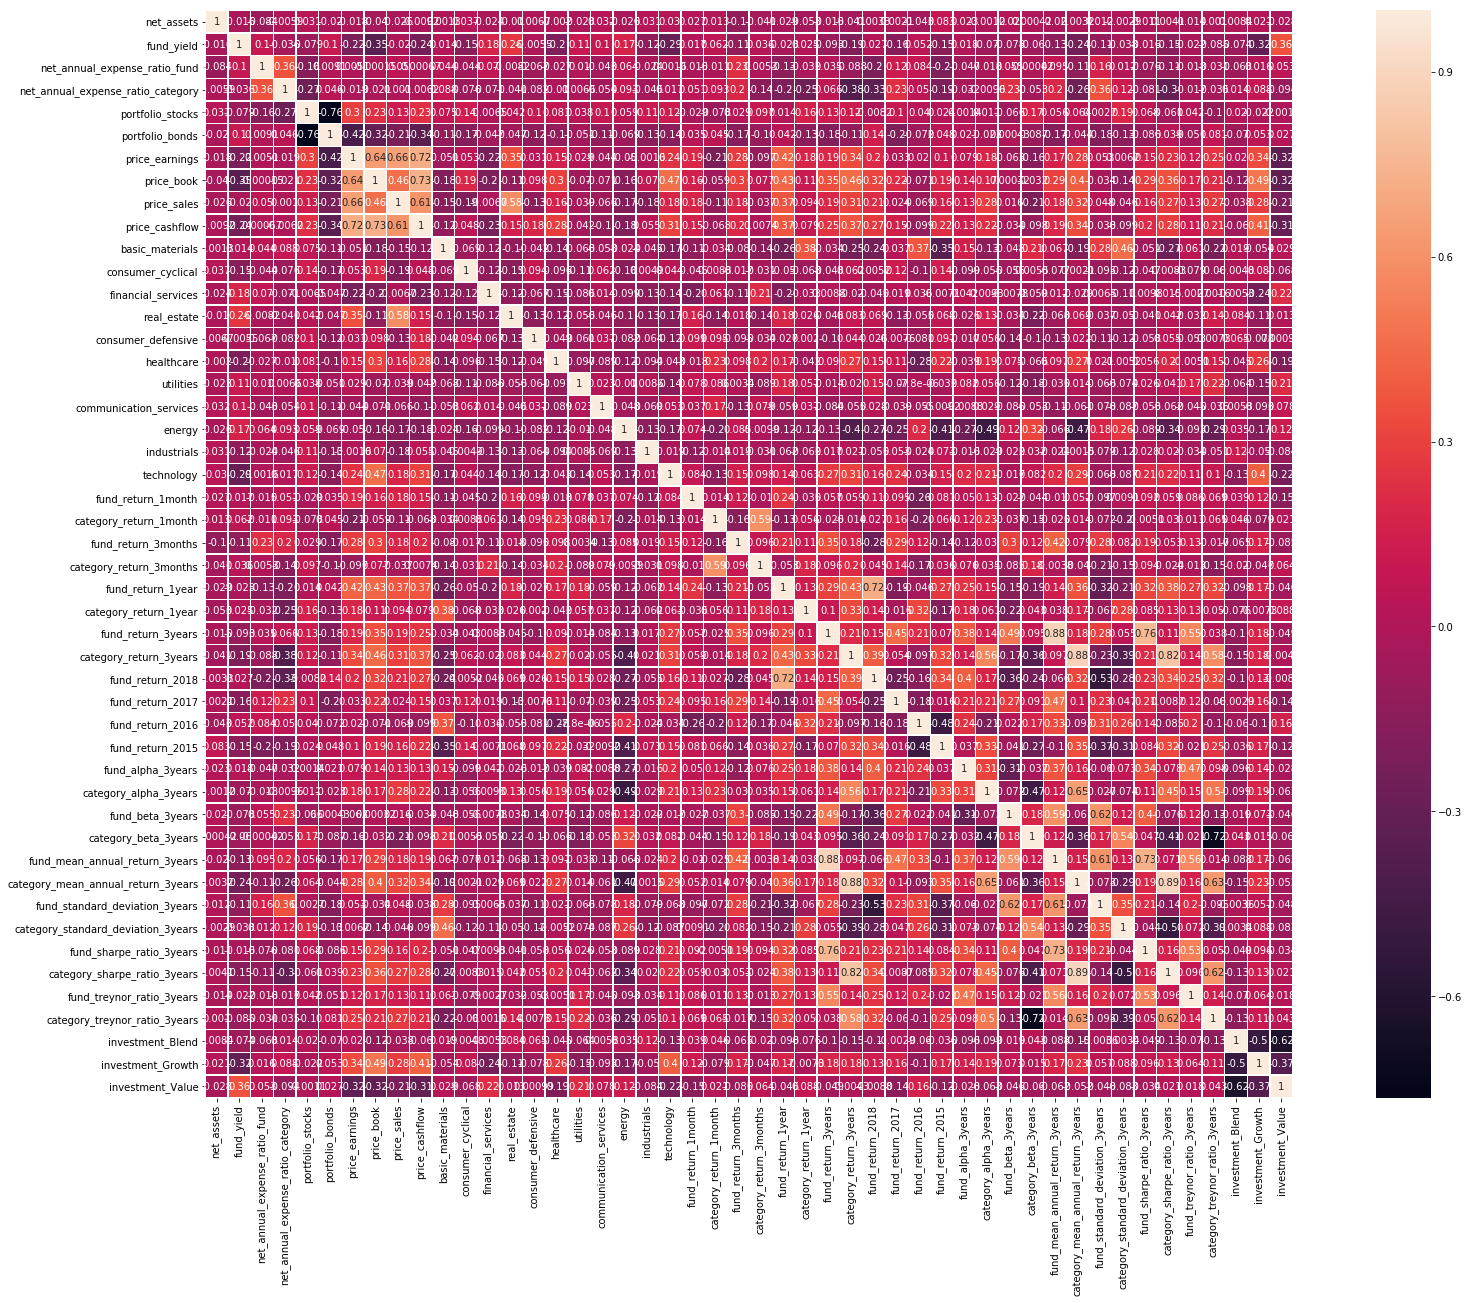

In [39]:
corrmat_etf = etf_df.corr()
plt.figure(figsize=(30,20))
sns.heatmap(corrmat_etf, square=True, annot=True, linewidths=.5)
plt.show()

List features that are highly correlated

In [40]:
high_corr = corrmat_etf.abs().where((corrmat_etf.abs() > 0.7) & (corrmat_etf.abs() < 1)).stack().to_dict()
high_corr_pd = pd.DataFrame.from_dict(high_corr, orient='index', columns = ['corr']).sort_values(by='corr', ascending=False)
high_corr_pd[::2]

,corr
"(category_mean_annual_return_3years, category_sharpe_ratio_3years)",0.892805
"(fund_return_3years, fund_mean_annual_return_3years)",0.884359
"(category_return_3years, category_mean_annual_return_3years)",0.877623
"(category_sharpe_ratio_3years, category_return_3years)",0.817512
"(portfolio_stocks, portfolio_bonds)",0.764533
"(fund_return_3years, fund_sharpe_ratio_3years)",0.764505
"(fund_sharpe_ratio_3years, fund_mean_annual_return_3years)",0.728435
"(price_book, price_cashflow)",0.726573
"(category_treynor_ratio_3years, category_beta_3years)",0.719981
"(fund_return_1year, fund_return_2018)",0.716763


List features that are highly correlated with the target (fund_return_2018)

In [41]:
corrmat_etf['fund_return_2018'].abs().sort_values(ascending=False)

fund_return_2018                      1.000000
fund_return_1year                     0.716763
fund_standard_deviation_3years        0.526627
fund_alpha_3years                     0.401552
category_return_3years                0.394222
fund_beta_3years                      0.364085
fund_return_2015                      0.344081
category_sharpe_ratio_3years          0.343297
net_annual_expense_ratio_category     0.331891
category_treynor_ratio_3years         0.322822
category_mean_annual_return_3years    0.322029
price_book                            0.316897
category_standard_deviation_3years    0.283833
fund_return_3months                   0.275939
price_cashflow                        0.271933
energy                                0.266670
fund_treynor_ratio_3years             0.253774
fund_return_2017                      0.253653
category_beta_3years                  0.241733
basic_materials                       0.237261
fund_sharpe_ratio_3years              0.227627
price_sales  

List variance of all the features

In [42]:
etf_df.var().sort_values()

net_annual_expense_ratio_category     2.053371e-02
category_beta_3years                  2.782025e-02
category_sharpe_ratio_3years          1.132410e-01
category_mean_annual_return_3years    1.346504e-01
net_annual_expense_ratio_fund         1.644401e-01
investment_Growth                     1.761429e-01
fund_sharpe_ratio_3years              1.778034e-01
investment_Value                      2.160095e-01
investment_Blend                      2.482726e-01
fund_mean_annual_return_3years        3.542630e-01
fund_beta_3years                      3.756287e-01
price_book                            1.296793e+00
price_sales                           1.430074e+00
fund_yield                            2.727517e+00
category_return_1month                2.873576e+00
fund_return_1month                    9.142047e+00
category_return_3months               1.108430e+01
price_cashflow                        1.503927e+01
category_alpha_3years                 1.686459e+01
category_standard_deviation_3ye

In [43]:
sel_ = SelectFromModel(linear_model.Lasso(alpha=0.01))

In [44]:
sel_.fit(X, Y)

SelectFromModel(estimator=Lasso(alpha=0.01, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=None,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [45]:
sel_.get_support()

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True, False,  True,  True,
       False,  True, False])

In [46]:
selected_feat = X.columns[(sel_.get_support())]
print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_==0)))

total features: 48
selected features: 40
features with coefficients shrank to zero: 7


In [47]:
removed_feats = X.columns[(sel_.estimator_.coef_==0).ravel().tolist()]
removed_feats.tolist()

['const',
 'category_return_1month',
 'category_beta_3years',
 'fund_mean_annual_return_3years',
 'category_sharpe_ratio_3years',
 'investment_Blend',
 'investment_Value']

Combining the result of correlation, variance, and Lasso feature selection result

In [48]:
drop_multicollinearity = list(set(removed_feats) - set(['const']))

In [49]:
# drop_multicollinearity = ['category_mean_annual_return_3years', 
#                           'fund_return_3years', 
#                           'price_earnings',  
#                           'price_cashflow',
#                           'price_book',
#                           'fund_sharpe_ratio_3years'
#                           ]

In [50]:
etf_df = etf_df.drop(columns=drop_multicollinearity)

In [51]:
Y = etf_df['fund_return_2018']
X = etf_df.loc[:,etf_df.columns!='fund_return_2018']

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       fund_return_2018   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     183.0
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        00:26:42   Log-Likelihood:                -4559.0
No. Observations:                1662   AIC:                             9202.
Df Residuals:                    1620   BIC:                             9430.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

### Linear Regression

Drop high p value (p>0.1)

In [52]:
pvalue = results.pvalues.abs().sort_values(ascending=False)
pvalue_df = pd.DataFrame(pvalue, columns = ['pvalue'])

In [53]:
drop_low_tvalue = list(pvalue_df.loc[pvalue_df['pvalue']>0.1].index)

etf_df = etf_df.drop(columns=drop_low_tvalue)

In [54]:
Y = etf_df['fund_return_2018']
X = etf_df.loc[:,etf_df.columns != 'fund_return_2018']

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       fund_return_2018   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     258.2
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        00:26:42   Log-Likelihood:                -4565.6
No. Observations:                1662   AIC:                             9191.
Df Residuals:                    1632   BIC:                             9354.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

Check the distribution of errors


Coefficients: 
 [-5.20882078e-16  1.34742306e-01  3.67759493e-02 -6.08124047e-02
  9.84868720e-01 -5.92830037e-01  1.31502249e-01  3.37485625e-02
  4.57676255e-02  3.28111760e-02  5.42944660e-02  3.88611767e-02
 -2.64283590e-02  4.87147345e-02 -9.77423611e-02 -3.08523555e-01
 -7.38198411e-02  4.54581621e-01  6.66863705e-02  1.27509174e-01
  1.67904834e-01 -9.29574375e-02 -9.00279849e-02 -4.08940706e-02
  3.21195605e-01 -1.15883343e-01 -1.95781845e+00 -1.44127651e-01
  6.48253558e-02  4.23617823e-02]

Intercept: 
 -8.76347365088932


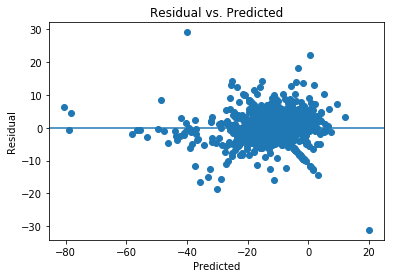

In [55]:
lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

predictions = lrm.predict(X)
errors = Y - predictions
np.mean(errors)

plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [56]:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 882.474 and p value is 6.34e-194
Levene test statistic value is 293.326 and p value is 4.44e-63


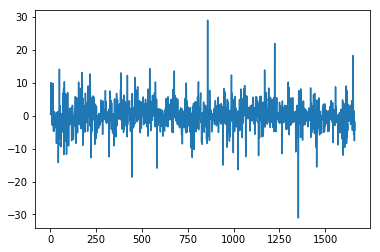

Jarque-Bera test statistics is 3994.57658908669 and p value is 0.0
Normality test statistics is 255.98619127446986 and p value is 2.590030289502381e-56


In [57]:
plt.plot(errors)
plt.show()

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

It's normally distributed

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1329
The number of observations in test set is 333


In [59]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the OLS model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics (OLS)-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the OLS model in the training set is: 0.8159410047487935
-----Test set statistics (OLS)-----
R-squared of the model in the test set is: 0.8355184460566867
Mean absolute error of the prediction is: 2.538304274514135
Mean squared error of the prediction is: 13.18439667918622
Root mean squared error of the prediction is: 3.6310324536123635
Mean absolute percentage error of the prediction is: 66.57271021776417


## Models

### Ridge CV

In [60]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [61]:
ridge_cv = RidgeCV(alphas=alphas, cv=10)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in the training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 100.0
R-squared of the model in the training set is: 0.8154390557968408
-----Test set statistics-----
R-squared of the model in the test set is: 0.833871707855793
Mean absolute error of the prediction is: 2.5366473419653315
Mean squared error of the prediction is: 13.316394761322735
Root mean squared error of the prediction is: 3.6491635700969525
Mean absolute percentage error of the prediction is: 65.5645094567813


### KNN

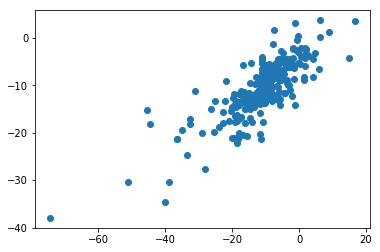

Unweighted Accuracy: 0.6024569114635024 (+/- 0.19867483877277478)
Training set score is 0.7092889509888973
Testing set score is 0.6051724768707131


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

knn = neighbors.KNeighborsRegressor(n_neighbors=10)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

knn.fit(X_train, y_train)

X_test = X_test.to_numpy()
y_ = knn.predict(X_test)

plt.scatter(y_test, y_)
plt.show()

score = cross_val_score(knn, X, Y, cv=10)
#print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('Unweighted Accuracy: {} (+/- {})'.format(score.mean(), score.std() * 2))
print('Training set score is {}'.format(knn.score(X_train, y_train)))
print('Testing set score is {}'.format(knn.score(X_test, y_test)))

In [63]:
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn, param_grid, cv=10)
knn_gscv.fit(X, Y)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=10, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [64]:
print('Best number of neighbors is {}'.format(knn_gscv.best_params_))
print('Best score is {}'.format(knn_gscv.best_score_))

Best number of neighbors is {'n_neighbors': 2}
Best score is 0.6675044103597925


### Random Forest

In [65]:
rfr = RandomForestRegressor(random_state=100, oob_score=True)
rfr.fit(X, Y)
print(cross_val_score(rfr, X, Y, cv=10))
print(rfr.oob_score_)

[0.52834771 0.84573586 0.80976939 0.9102827  0.83323093 0.75998984
 0.80601873 0.81587463 0.80115092 0.87511644]
0.8276961706641739


In [68]:
rfr = RandomForestRegressor(random_state=100)
param_grid = {"n_estimators" : [10,50,100],
              "max_features" : ["auto", "log2", "sqrt"],
              "bootstrap"    : [True, False]
             }


rfr_gscv = GridSearchCV(rfr, param_grid, cv=10)
rfr_gscv.fit(X, Y)
print('Best estimator is {}'.format(rfr_gscv.best_estimator_))
print('Best score is {}'.format(rfr_gscv.best_score_))

Best estimator is RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)
Best score is 0.7985517138561872


## Conclusion

Linear Regression and Ridge cross validation results in the best performance. Given the features of an ETF, we can estimate what's the return of the fund for year. There might be features that have overlapping, further research can be done to narrow down the features